In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [21]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/Ass 01/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# Creating a db

In [4]:
conn = sqlite3.connect('imdb_reviews.db')
cursor = conn.cursor()

In [5]:
create_table_query = """
CREATE TABLE IF NOT EXISTS imdb_reviews (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    review_text TEXT,
    sentiment TEXT
);
"""

cursor.execute(create_table_query)
conn.commit()

In [6]:
df.to_sql('imdb_reviews', conn, if_exists='replace', index=False)

50000

In [7]:
query = 'Select * from imdb_reviews'

result = pd.read_sql_query(query, conn)
print(result)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [8]:
conn.close()

# Data Cleaning and exploration

In [10]:
df.isnull().sum()

,0
review,0
sentiment,0


In [23]:
df.duplicated().sum()

418

In [24]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [25]:
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def cleaning_and_stemming(text):
  text = BeautifulSoup(text, 'html.parser').get_text()
  text =text.lower()
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  #removing stopwords
  text = " ".join(word for word in text.split() if word not in set(stopwords.words('english')))
  #stemming
  text = ' '.join(stemmer.stem(wrd) for wrd in text.split())
  return text



In [27]:
df['cleaned']=df['review'].apply(cleaning_and_stemming)
df['cleaned'].head()

<ipython-input-26-ce5076711781>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


,cleaned
0,one review mention watch oz episod youll hook ...
1,wonder littl product film techniqu unassum old...
2,thought wonder way spend time hot summer weeke...
3,basic there famili littl boy jake think there ...
4,petter mattei love time money visual stun film...


# Exploratory Data Analysis

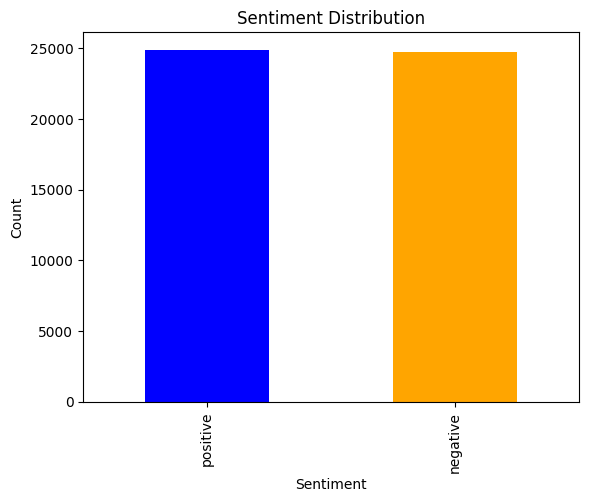

In [28]:
import matplotlib.pyplot as plt
sentiment_counts = df['sentiment'].value_counts()

sentiment_counts.plot(kind="bar", color=["blue", "orange"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

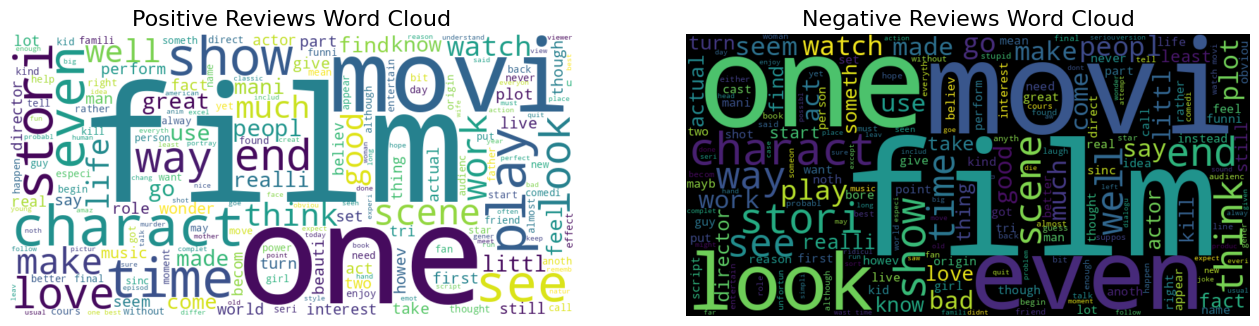

In [29]:
from wordcloud import WordCloud

# Word Cloud for positive reviews
positive_reviews = " ".join(df[df["sentiment"] == "positive"]["cleaned"])
wordcloud_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_reviews)

# Word Cloud for negative reviews
negative_reviews = " ".join(df[df["sentiment"] == "negative"]["cleaned"])
wordcloud_negative = WordCloud(width=800, height=400, background_color="black").generate(negative_reviews)

# Plot word clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.title("Positive Reviews Word Cloud", fontsize=16)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.title("Negative Reviews Word Cloud", fontsize=16)
plt.axis("off")
plt.show()


sentiment
negative    725.942505
positive    753.047942
Name: review_length, dtype: float64


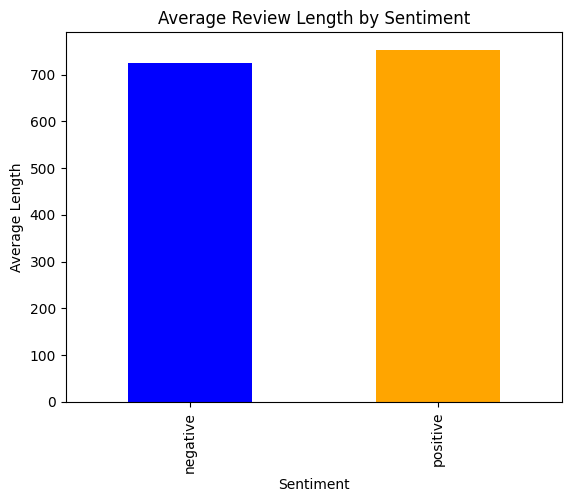

In [30]:
# Add a column for review lengths
df["review_length"] = df["cleaned"].apply(len)

# Calculate average lengths
average_lengths = df.groupby("sentiment")["review_length"].mean()
print(average_lengths)

# Plot average review lengths
average_lengths.plot(kind="bar", color=["blue", "orange"])
plt.title("Average Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Length")
plt.show()


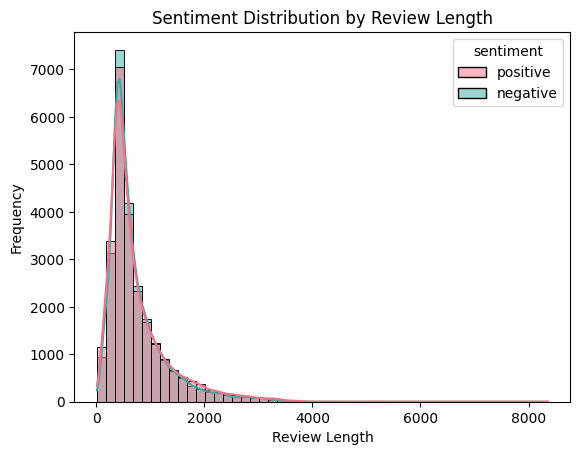

In [31]:
import seaborn as sns

sns.histplot(data=df, x="review_length", hue="sentiment", kde=True, bins=50, palette="husl")
plt.title("Sentiment Distribution by Review Length")
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.show()


# model training

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle

In [34]:
def train_model(data):
    # Convert sentiment labels to numeric
    data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

    # Initialize TF-IDF vectorizer
    tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
    X = tfidf.fit_transform(data["cleaned"]).toarray()
    y = data["sentiment"]

    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Train logistic regression
    model_LR = LogisticRegression()
    model_LR.fit(X_train, y_train)

    # Validation metrics
    y_val_pred = model_LR.predict(X_val)
    print("Validation Metrics:")
    print(classification_report(y_val, y_val_pred))

    # Final evaluation on test set
    y_test_pred = model_LR.predict(X_test)
    print("Test Metrics:")
    print(classification_report(y_test, y_test_pred))



    # Save the TF-IDF vectorizer
    with open('tfidf_vectorizer.pkl', 'wb') as f:
      pickle.dump(tfidf, f)

    with open('logistic_model.pkl', 'wb') as f:
        pickle.dump(model_LR, f)


In [35]:
train_model(df)

Validation Metrics:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      3728
           1       0.87      0.90      0.88      3709

    accuracy                           0.88      7437
   macro avg       0.88      0.88      0.88      7437
weighted avg       0.88      0.88      0.88      7437

Test Metrics:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3676
           1       0.88      0.89      0.88      3762

    accuracy                           0.88      7438
   macro avg       0.88      0.88      0.88      7438
weighted avg       0.88      0.88      0.88      7438

